In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import models, metrics, AND StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler # <--- IMPORTADO
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ==============================================================================
# --- 1. Load and Preprocess the Data ---
# ==============================================================================
print("--- Loading and Preprocessing Data ---")

# Load the raw dataset created by our loader script
file_path = '../data/raw/leish_dataset.csv'
df = pd.read_csv(file_path)

# Create a copy for preprocessing
df_processed = df.copy()

# Handle Missing Values
# (Corrigindo os espaços não-padrão do seu original)
for col in df_processed.select_dtypes(include=['object']).columns:
    df_processed[col] = df_processed[col].fillna('Unknown')

# Encode the Target Variable
target_map = {'positivo': 1, 'negativo': 0, 'Unknown': 0}
df_processed['diagnosis'] = df_processed['diagnosis'].map(target_map).astype(int)

# Separate features from the target before encoding
X_categorical = df_processed.drop('diagnosis', axis=1)
y = df_processed['diagnosis']

# Apply One-Hot Encoding to categorical features
X_numeric = pd.get_dummies(X_categorical, drop_first=False, dtype=int)

print("--- Data Preprocessing Complete ---")
# Esta linha agora vai funcionar, pois X_numeric foi definido acima
print(f"Shape of numerical features (X): {X_numeric.shape}")


# ==============================================================================
# --- 2. Split the Data into Training and Test sets ---
# ==============================================================================
# We now use the processed X_numeric and y
X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y, test_size=0.2, random_state=42, stratify=y
)

print("\n--- Data Split ---")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Positive cases in test set: {y_test.sum()} out of {len(y_test)}")


# ==============================================================================
# --- 3. [NOVO] Create Scaled Data for Linear Models ---
# ==============================================================================
print("\n--- 3. Creating Scaled Data for LR ---")
scaler = StandardScaler()

# Ajuste o scaler SOMENTE no treino (X_train)
X_train_scaled = scaler.fit_transform(X_train)

# Transforme o teste (X_test) com o scaler já treinado
X_test_scaled = scaler.transform(X_test)
print("--- Scaled data created ---")


# ==============================================================================
# --- 4. Model 1: Logistic Regression (Balanced) ---
# ==============================================================================
print("\n--- Training Model 1: Logistic Regression (Balanced) ---")
log_reg_balanced = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)
# Treine o LR com os dados ESCALADOS
log_reg_balanced.fit(X_train_scaled, y_train)

# Faça a predição com os dados de teste ESCALADOS
y_pred_log_reg = log_reg_balanced.predict(X_test_scaled)

print("\n--- Logistic Regression Performance ---")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log_reg))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log_reg))


# ==============================================================================
# --- 5. Model 2: Random Forest (Optimized) ---
# ==============================================================================
print("\n--- Training Model 2: Random Forest (Optimized) ---")
# Using the best parameters found during our hyperparameter tuning
best_rf_params = {
    'class_weight': 'balanced_subsample', 'criterion': 'entropy',
    'max_depth': 20, 'min_samples_leaf': 4,
    'min_samples_split': 10, 'n_estimators': 300
}
rf_clf_best = RandomForestClassifier(random_state=42, **best_rf_params)

# Treine o RF com os dados ORIGINAIS (NÃO escalados)
rf_clf_best.fit(X_train, y_train)
y_pred_rf = rf_clf_best.predict(X_test)

print("\n--- Random Forest Performance ---")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


# ==============================================================================
# --- 6. Model 3: XGBoost Classifier ---
# ==============================================================================
print("\n--- Training Model 3: XGBoost Classifier ---")

# Calculate the scale_pos_weight for handling class imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Calculated scale_pos_weight for XGBoost: {scale_pos_weight:.2f}")

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

# Treine o XGBoost com os dados ORIGINAIS (NÃO escalados)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)

print("\n--- XGBoost Performance ---")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

--- Loading and Preprocessing Data ---
--- Data Preprocessing Complete ---
Shape of numerical features (X): (456, 59)

--- Data Split ---
Training set shape: (364, 59)
Test set shape: (92, 59)
Positive cases in test set: 27 out of 92

--- 3. Creating Scaled Data for LR ---
--- Scaled data created ---

--- Training Model 1: Logistic Regression (Balanced) ---

--- Logistic Regression Performance ---
Confusion Matrix:
[[46 19]
 [13 14]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        65
           1       0.42      0.52      0.47        27

    accuracy                           0.65        92
   macro avg       0.60      0.61      0.60        92
weighted avg       0.68      0.65      0.66        92


--- Training Model 2: Random Forest (Optimized) ---

--- Random Forest Performance ---
Confusion Matrix:
[[47 18]
 [14 13]]

Classification Report:
              precision    recall  f1-score   support

       



--- 7. BÔNUS: Extraindo a Importância das Features do XGBoost ---

--- Top 10 Features Mais Preditivas (XGBoost) ---
                                    Feature  Importance
24  conjunctivitis_Ceratoconjuntivite Grave    0.054477
19              lymph_nodes_leves_moderadas    0.053590
28                         bleeding_ausente    0.047905
32                skin_lesion_Leve/Moderada    0.045925
7                   nutritional_state_grave    0.039270
25         conjunctivitis_Conjuntivite Leve    0.038350
31           skin_lesion_Grave/Generalizada    0.036817
17                muzzle_ear_lesion_ausente    0.035593
15       mucosa_color_levemente_hipercorada    0.034411
8           nutritional_state_leve_moderado    0.034089


/tmp/ipykernel_345191/2234646158.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



--- Gráfico de importância das features salvo como 'xgboost_feature_importance.png' ---


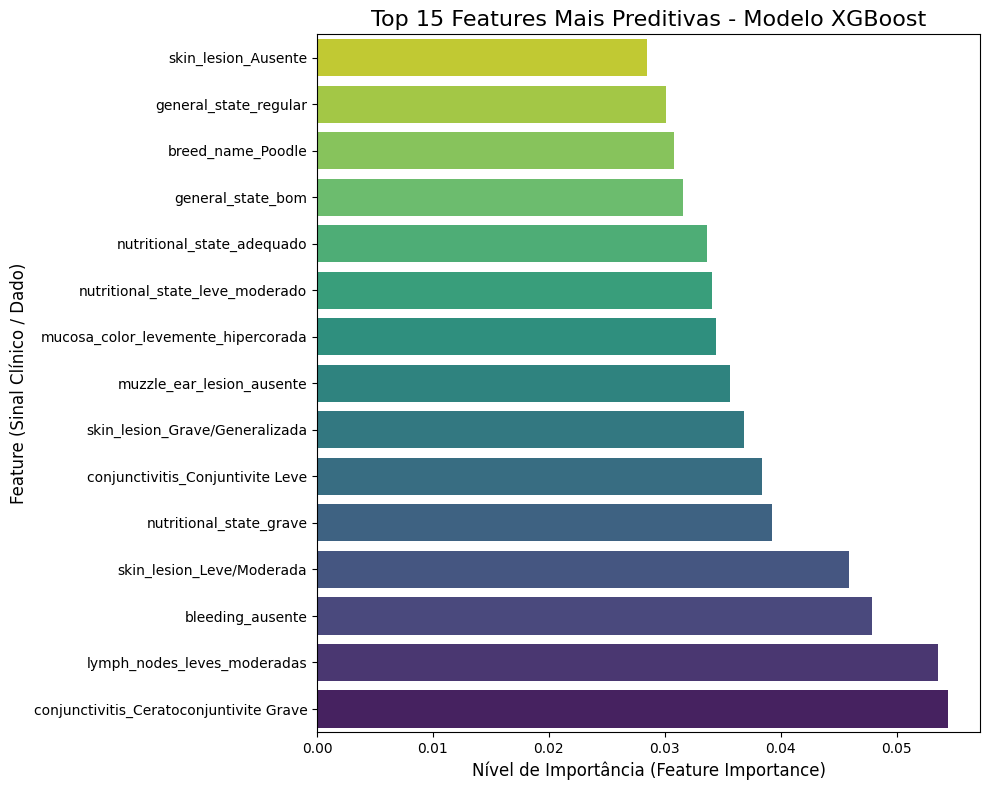

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# --- 7. BÔNUS: Importância das Features (XGBoost) ---
# ==============================================================================
print("\n\n--- 7. BÔNUS: Extraindo a Importância das Features do XGBoost ---")

# O modelo 'xgb_clf' já foi treinado na Etapa 6.
# Os nomes das colunas estão em 'X_numeric.columns' (criado na Etapa 1)

# 1. Extrair os nomes das features
feature_names = X_numeric.columns.tolist()

# 2. Extrair a importância (o "peso") de cada feature
importances = xgb_clf.feature_importances_

# 3. Criar um DataFrame do Pandas para facilitar a análise
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False) # Ordenar pela mais importante

# 4. Exibir as Top 10 features no console
print("\n--- Top 10 Features Mais Preditivas (XGBoost) ---")
print(feature_importance_df.head(10))

# 5. Criar um gráfico de barras para visualização (Top 15)
plt.figure(figsize=(10, 8)) # Ajuste o tamanho conforme necessário
top_features_df = feature_importance_df.head(15)

# Usar seaborn para um visual mais agradável
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=top_features_df,
    palette='viridis' # Esquema de cores
)

plt.title('Top 15 Features Mais Preditivas - Modelo XGBoost', fontsize=16)
plt.xlabel('Nível de Importância (Feature Importance)', fontsize=12)
plt.ylabel('Feature (Sinal Clínico / Dado)', fontsize=12)
plt.gca().invert_yaxis() # Mostrar a feature mais importante no topo
plt.tight_layout() # Ajustar layout para não cortar os nomes

# 6. Salvar o gráfico para sua tese/artigo
plt.savefig("xgboost_feature_importance.png", dpi=300)
print("\n--- Gráfico de importância das features salvo como 'xgboost_feature_importance.png' ---")
# plt.show() # Descomente esta linha se estiver rodando interativamente no Jupyter